In [1]:
%pip install wbdata

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import wbdata
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import requests
import urllib3
import re

# Suppress only the single InsecureRequestWarning from urllib3 needed to disable SSL verification warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

from utils import (
    MACRO_ECO_FACTORS_DATA_FILE_PATH,
    INTEREST_RATES_DATA_FILE_PATH,
    WORLD_BANK_DATA_FILE_PATH,
    TRAIN_START_DATE,
    STLOUISFED_API_KEY,
    COUNTRIES,
    MISSING_USA_INTEREST_RATES,
    human_readable_format,
    COUNTRIES_SERIES_IDS)

# Convert TRAIN_START_DATE to a datetime object
train_start_year = pd.to_datetime(TRAIN_START_DATE).year

# Inflation, GDP from World Bank API

In [3]:
# Define the countries and indicators
countries = list(COUNTRIES.keys())

print(countries)

indicators = {
    # 'FR.INR.LEND': 'interest_rate',  # Lending interest rate (%)
    'FP.CPI.TOTL': 'inflation_rate',  # Consumer price index (2010 = 100)
    'NY.GDP.MKTP.CD': 'gdp',
    # 'EG.USE.PCAP.KG.OE': 'energy_consumption'  # Energy use (kg of oil equivalent per capita)
}

# Fetch data from World Bank API
data = wbdata.get_dataframe(indicators, country=countries)

# Reset index and process data
data.reset_index(inplace=True)

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data.sort_index(ascending=False, inplace=True)
data.fillna(0, inplace=True)

# Clean up special characters from country names
def clean_country_name(name):
    name = re.sub(r'[\"\.\,]', '', name)
    return name

# Apply the function to the 'country' column
data['country'] = data['country'].apply(clean_country_name)

# Pivot the data to have separate columns for each country's interest and inflation rates
world_bank_data = data.pivot_table(index='date', columns='country', values=['inflation_rate', 'gdp'])
world_bank_data.columns = ['_'.join(col).strip() for col in world_bank_data.columns.values]
world_bank_data.reset_index(inplace=True)

# Replace 0 with NaN
world_bank_data.replace(0, np.nan, inplace=True)

# Filter the data after the training date
world_bank_data.set_index('date', inplace=True)
world_bank_data = world_bank_data[world_bank_data.index.year >= train_start_year]
world_bank_data.to_csv(WORLD_BANK_DATA_FILE_PATH)

world_bank_data.head(30)


['USA', 'GBR', 'CHN', 'DEU', 'JPN', 'IND', 'BRA', 'RUS', 'CAN', 'AUS', 'FRA', 'ITA', 'KOR', 'MEX', 'SAU']


,gdp_Australia,gdp_Brazil,gdp_Canada,gdp_China,gdp_France,gdp_Germany,gdp_India,gdp_Italy,gdp_Japan,gdp_Korea Rep,...,inflation_rate_Germany,inflation_rate_India,inflation_rate_Italy,inflation_rate_Japan,inflation_rate_Korea Rep,inflation_rate_Mexico,inflation_rate_Russian Federation,inflation_rate_Saudi Arabia,inflation_rate_United Kingdom,inflation_rate_United States
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.330382e+12,1.476107e+12,1.655685e+12,1.468774e+13,2.647419e+12,3.887727e+12,2.674852e+12,1.897462e+12,5.055587e+12,1.644313e+12,...,113.018379,182.988823,110.471259,105.457901,115.777368,146.350488,186.862622,122.479242,120.806362,118.690502
2021-01-01,1.559034e+12,1.670647e+12,2.007472e+12,1.782046e+13,2.959356e+12,4.278504e+12,3.167271e+12,2.154875e+12,5.034621e+12,1.818432e+12,...,116.484276,192.378725,112.541251,105.211812,118.669872,154.676672,199.372063,126.231136,123.848715,124.266414
2022-01-01,1.692957e+12,1.951924e+12,2.161483e+12,1.788178e+13,2.779092e+12,4.082469e+12,3.353470e+12,2.066972e+12,4.256411e+12,1.673917e+12,...,124.489744,205.266241,121.771085,107.839691,124.709592,166.890369,NaN,129.354188,133.660070,134.211206
2023-01-01,1.723827e+12,2.173666e+12,2.140086e+12,1.779478e+13,3.030904e+12,4.456081e+12,3.549919e+12,2.254851e+12,4.212945e+12,1.712793e+12,...,131.892448,216.862025,128.617292,111.364036,129.190176,176.116004,NaN,132.364370,142.740891,139.735794


# Interest rate from fred.stlouisfed 

In [4]:
# Function to fetch data from FRED API and bypass SSL verification
def fetch_fred_series(series_id, start_date):
    url = f'https://api.stlouisfed.org/fred/series/observations'
    params = {
        'series_id': series_id,
        'api_key': STLOUISFED_API_KEY,
        'file_type': 'json',
        'observation_start': start_date
    }
    response = requests.get(url, params=params, verify=False)  # Bypass SSL verification
    if response.status_code == 200:
        data = response.json()
        observations = data['observations']
        
        if not observations:
            print(f"No data found for series {series_id}")
            return pd.DataFrame()
        
        df = pd.DataFrame(observations)
        if 'date' not in df.columns:
            print(f"'date' column not found in data for series {series_id}")
            print(df.head())
            return pd.DataFrame()
        
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df['value'] = pd.to_numeric(df['value'], errors='coerce')  # Convert to numeric, setting errors to NaN
        return df.drop(columns=['realtime_start', 'realtime_end'])
    else:
        print(f"Error fetching data for series {series_id}: {response.status_code}")
        return pd.DataFrame()

# Fetch data for each country and combine into a single DataFrame
interest_rate_data = pd.DataFrame()

for country, series_id in COUNTRIES_SERIES_IDS.items():
    country_data = fetch_fred_series(series_id, '2020-01-01')
    if not country_data.empty:
        country_data.rename(columns={'value': f'interest_rate_{country}'}, inplace=True)
        if interest_rate_data.empty:
            interest_rate_data = country_data
        else:
            interest_rate_data = interest_rate_data.join(country_data, how='outer')

interest_rate_data.head()

No data found for series INTGSTSAM193N


,interest_rate_United States,interest_rate_United Kingdom,interest_rate_China,interest_rate_Germany,interest_rate_Japan,interest_rate_India,interest_rate_Italy,interest_rate_Australia,interest_rate_Canada,interest_rate_France,interest_rate_Brazil,interest_rate_Russia,interest_rate_South Korea,interest_rate_Mexico
date,,,,,,,,,,,,,,
2020-01-01,2.25,0.74,3.67,-0.391136,0.021,5.046667,-0.391136,0.89,1.912474,-0.391136,4.50,NaN,1.47,7.44
2020-02-01,2.25,0.75,2.98,-0.408850,0.021,NaN,-0.408850,0.89,1.802298,-0.408850,4.25,6.07,1.42,7.30
2020-03-01,0.25,0.53,2.55,-0.416636,0.006,NaN,-0.416636,0.53,1.268552,-0.416636,3.75,6.72,1.23,6.98
2020-04-01,0.25,0.65,2.32,-0.254050,-0.039,3.620000,-0.254050,0.17,0.482846,-0.254050,3.75,NaN,1.10,6.43
2020-05-01,0.25,0.33,2.13,-0.271950,-0.042,NaN,-0.271950,0.10,0.345921,-0.271950,3.14,NaN,1.02,5.93


# Add missing USA interest rates

In [5]:
missing_rates_df = pd.DataFrame.from_dict(MISSING_USA_INTEREST_RATES, orient='index', columns=['interest_rate_United States'])
missing_rates_df.index = pd.to_datetime(missing_rates_df.index)

# Merge the missing rates DataFrame with the original DataFrame
interest_rate_data = interest_rate_data.combine_first(missing_rates_df)

# Reset index to get the date column back
interest_rate_data.reset_index(inplace=True)

# Rename the index column to 'date' if necessary
if 'index' in interest_rate_data.columns:
    interest_rate_data.rename(columns={'index': 'date'}, inplace=True)

interest_rate_data['date'] = pd.to_datetime(interest_rate_data['date'])
interest_rate_data.set_index('date', inplace=True)
interest_rate_data = interest_rate_data[interest_rate_data.index.year >= train_start_year]
interest_rate_data.reset_index(inplace=True)

interest_rate_data.to_csv(INTEREST_RATES_DATA_FILE_PATH)
interest_rate_data.head()

,date,interest_rate_Australia,interest_rate_Brazil,interest_rate_Canada,interest_rate_China,interest_rate_France,interest_rate_Germany,interest_rate_India,interest_rate_Italy,interest_rate_Japan,interest_rate_Mexico,interest_rate_Russia,interest_rate_South Korea,interest_rate_United Kingdom,interest_rate_United States
0,2020-01-01,0.89,4.50,1.912474,3.67,-0.391136,-0.391136,5.046667,-0.391136,0.021,7.44,NaN,1.47,0.74,2.25
1,2020-02-01,0.89,4.25,1.802298,2.98,-0.408850,-0.408850,NaN,-0.408850,0.021,7.30,6.07,1.42,0.75,2.25
2,2020-03-01,0.53,3.75,1.268552,2.55,-0.416636,-0.416636,NaN,-0.416636,0.006,6.98,6.72,1.23,0.53,0.25
3,2020-04-01,0.17,3.75,0.482846,2.32,-0.254050,-0.254050,3.620000,-0.254050,-0.039,6.43,NaN,1.10,0.65,0.25
4,2020-05-01,0.10,3.14,0.345921,2.13,-0.271950,-0.271950,NaN,-0.271950,-0.042,5.93,NaN,1.02,0.33,0.25


In [6]:
# Load the datasets
interest_rate_data = pd.read_csv(INTEREST_RATES_DATA_FILE_PATH)
world_bank_data = pd.read_csv(WORLD_BANK_DATA_FILE_PATH)

# Drop the 'Unnamed: 0' column if it exists
interest_rate_data = interest_rate_data.drop(columns=['Unnamed: 0'], errors='ignore')
world_bank_data = world_bank_data.drop(columns=['Unnamed: 0'], errors='ignore')

# Ensure 'date' columns are in datetime format
interest_rate_data['date'] = pd.to_datetime(interest_rate_data['date'])
world_bank_data['date'] = pd.to_datetime(world_bank_data['date'])

# Set 'date' as the index
interest_rate_data.set_index('date', inplace=True)
world_bank_data.set_index('date', inplace=True)

# Generate a date range that includes all months up to the end of 2023
all_months = pd.date_range(start=world_bank_data.index.min(), end='2024-01-01', freq='MS')

# Reindex the world bank data to include all months up to the end of 2023 and forward-fill values
monthly_from_yearly = world_bank_data.reindex(all_months).ffill()

# Shift dates to the first of each month
monthly_from_yearly.index = monthly_from_yearly.index - pd.offsets.MonthBegin(1)

# Reset index to get the date column back
monthly_from_yearly.reset_index(inplace=True)
monthly_from_yearly.rename(columns={'index': 'date'}, inplace=True)

# Ensure the 'date' columns in both datasets are aligned to the first of the month
interest_rate_data.index = interest_rate_data.index - pd.offsets.MonthBegin(1)
interest_rate_data.reset_index(inplace=True)

# Merge the two DataFrames on the date column
merged_df = pd.merge(interest_rate_data, monthly_from_yearly, on='date', how='outer')

# Add a 'year' column for convenience
merged_df['year'] = merged_df['date'].dt.year

# Reset index to get the date column back
merged_df.reset_index(drop=True, inplace=True)

# Save the resulting DataFrame to a CSV file
merged_df.to_csv(MACRO_ECO_FACTORS_DATA_FILE_PATH, index=False)

# Display the first few rows of the updated DataFrame
merged_df.head(100)


,date,interest_rate_Australia,interest_rate_Brazil,interest_rate_Canada,interest_rate_China,interest_rate_France,interest_rate_Germany,interest_rate_India,interest_rate_Italy,interest_rate_Japan,...,inflation_rate_India,inflation_rate_Italy,inflation_rate_Japan,inflation_rate_Korea Rep,inflation_rate_Mexico,inflation_rate_Russian Federation,inflation_rate_Saudi Arabia,inflation_rate_United Kingdom,inflation_rate_United States,year
0,2019-12-01,0.89,4.50,1.912474,3.67,-0.391136,-0.391136,5.046667,-0.391136,0.021,...,182.988823,110.471259,105.457901,115.777368,146.350488,186.862622,122.479242,120.806362,118.690502,2019
1,2020-01-01,0.89,4.25,1.802298,2.98,-0.408850,-0.408850,NaN,-0.408850,0.021,...,182.988823,110.471259,105.457901,115.777368,146.350488,186.862622,122.479242,120.806362,118.690502,2020
2,2020-02-01,0.53,3.75,1.268552,2.55,-0.416636,-0.416636,NaN,-0.416636,0.006,...,182.988823,110.471259,105.457901,115.777368,146.350488,186.862622,122.479242,120.806362,118.690502,2020
3,2020-03-01,0.17,3.75,0.482846,2.32,-0.254050,-0.254050,3.620000,-0.254050,-0.039,...,182.988823,110.471259,105.457901,115.777368,146.350488,186.862622,122.479242,120.806362,118.690502,2020
4,2020-04-01,0.10,3.14,0.345921,2.13,-0.271950,-0.271950,NaN,-0.271950,-0.042,...,182.988823,110.471259,105.457901,115.777368,146.350488,186.862622,122.479242,120.806362,118.690502,2020
5,2020-05-01,0.10,2.69,0.305564,2.54,-0.376000,-0.376000,NaN,-0.376000,-0.042,...,182.988823,110.471259,105.457901,115.777368,146.350488,186.862622,122.479242,120.806362,118.690502,2020
6,2020-06-01,0.10,2.25,0.282999,2.76,-0.444130,-0.444130,3.243333,-0.444130,-0.065,...,182.988823,110.471259,105.457901,115.777368,146.350488,186.862622,122.479242,120.806362,118.690502,2020
7,2020-07-01,0.10,2.03,0.255650,2.97,-0.479714,-0.479714,NaN,-0.479714,-0.065,...,182.988823,110.471259,105.457901,115.777368,146.350488,186.862622,122.479242,120.806362,118.690502,2020
8,2020-08-01,0.09,2.00,0.251416,2.99,-0.491364,-0.491364,NaN,-0.491364,-0.055,...,182.988823,110.471259,105.457901,115.777368,146.350488,186.862622,122.479242,120.806362,118.690502,2020
9,2020-09-01,0.07,2.00,0.245218,3.18,-0.509136,-0.509136,3.136667,-0.509136,-0.055,...,182.988823,110.471259,105.457901,115.777368,146.350488,186.862622,122.479242,120.806362,118.690502,2020


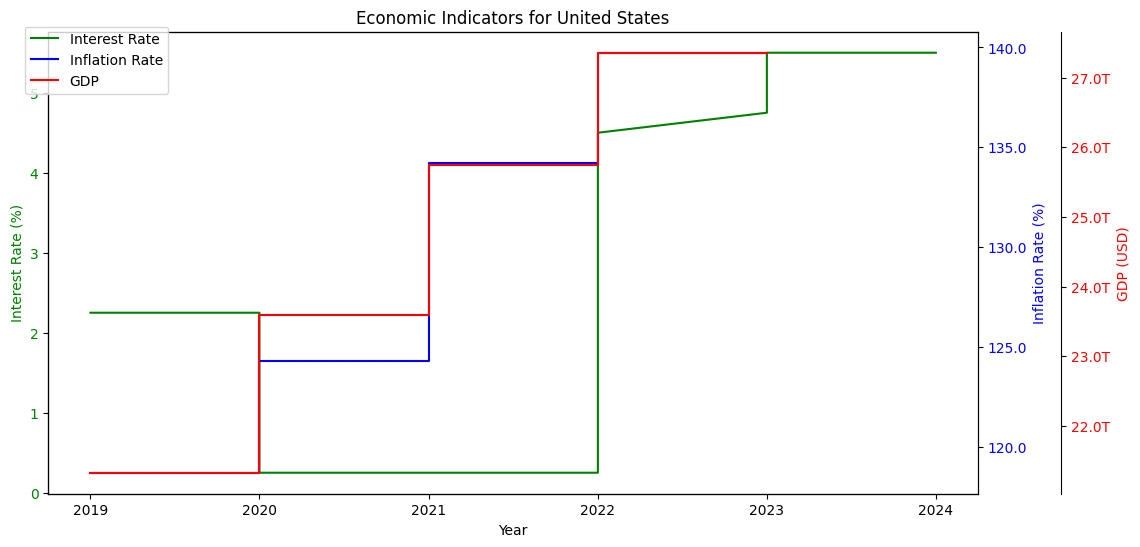

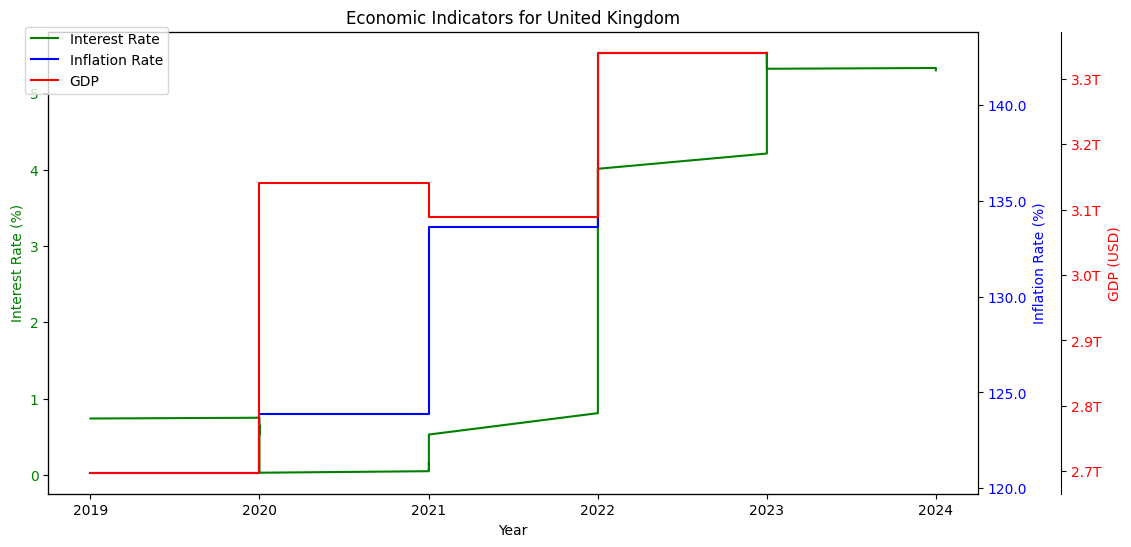

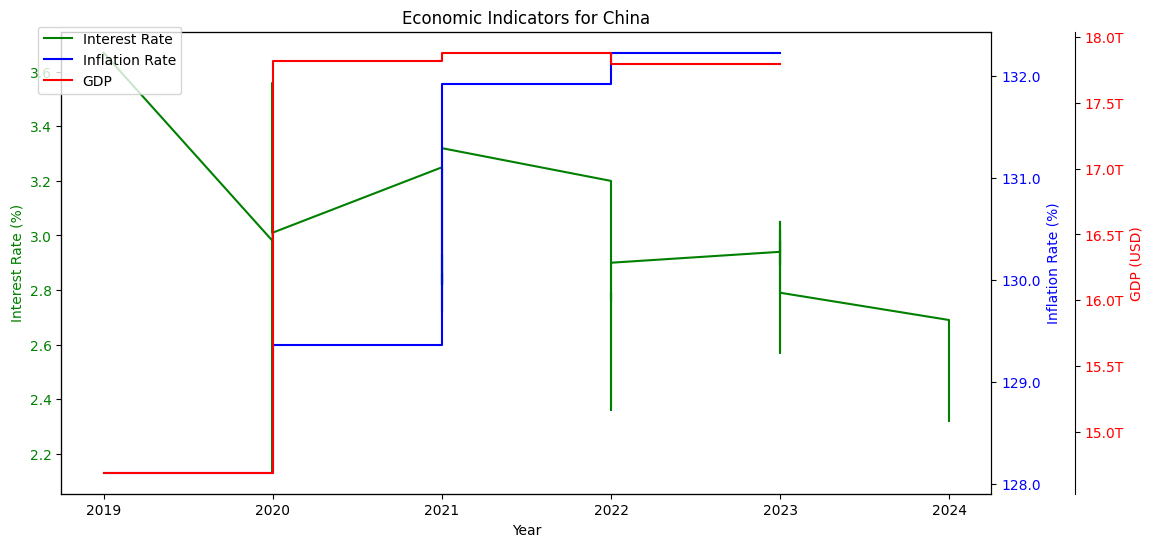

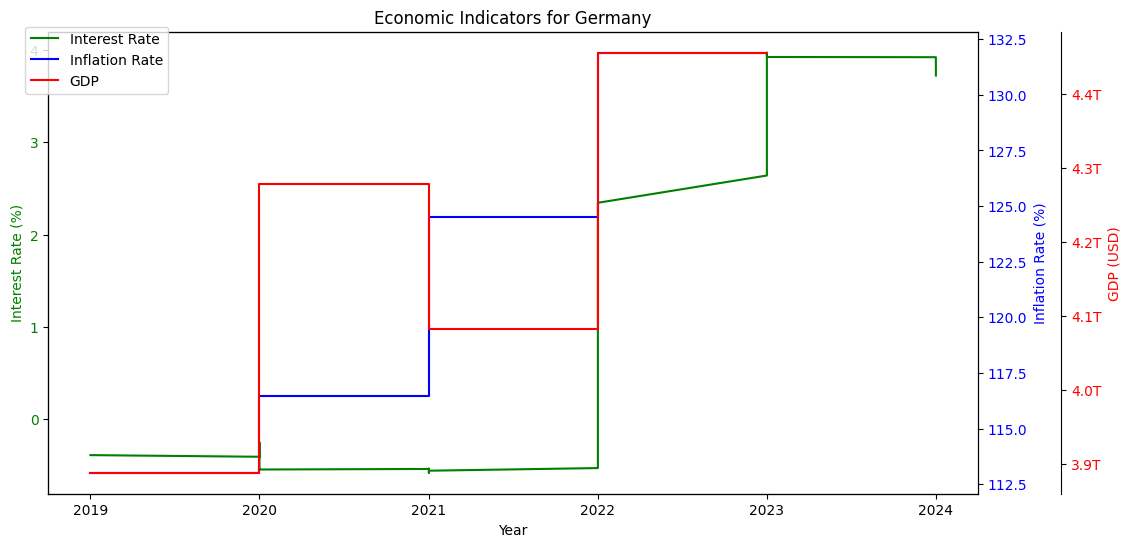

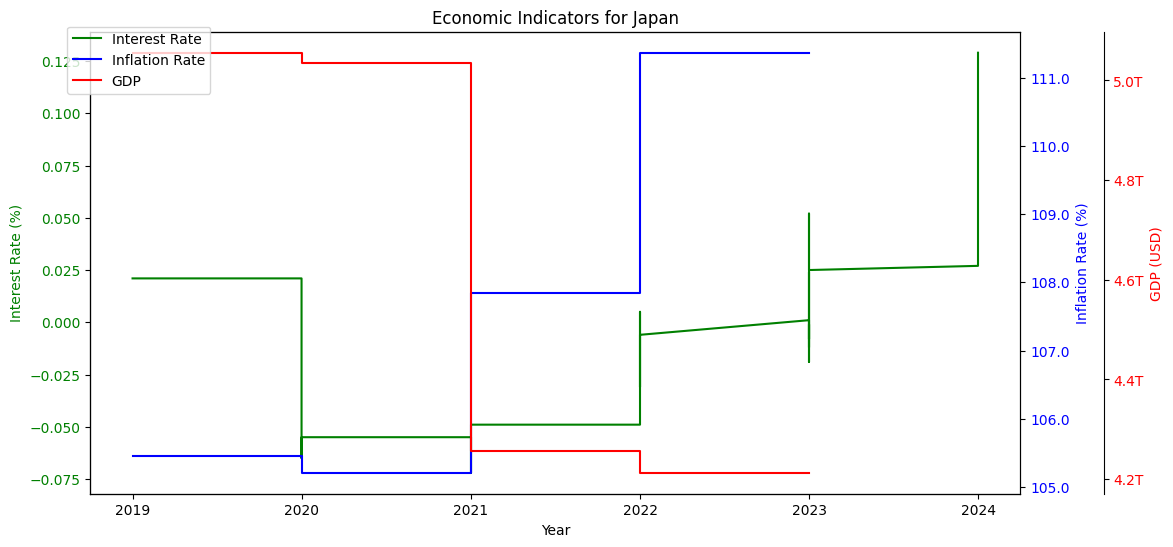

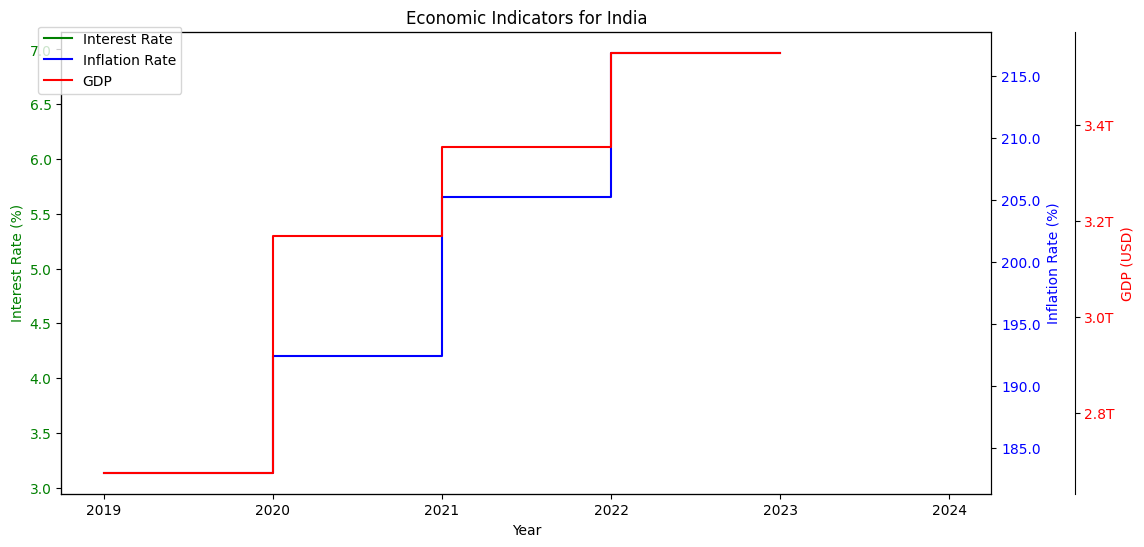

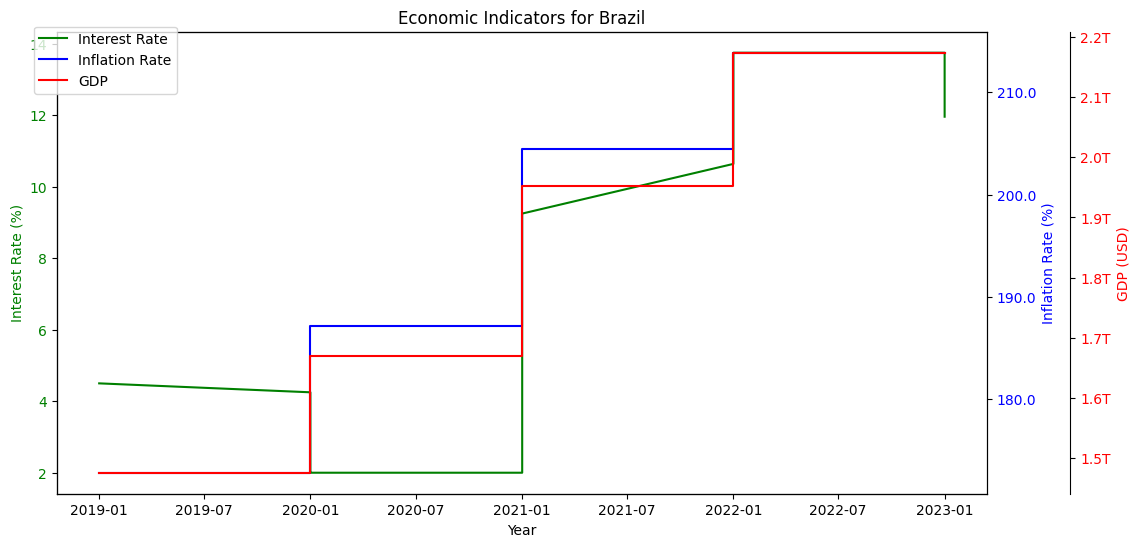

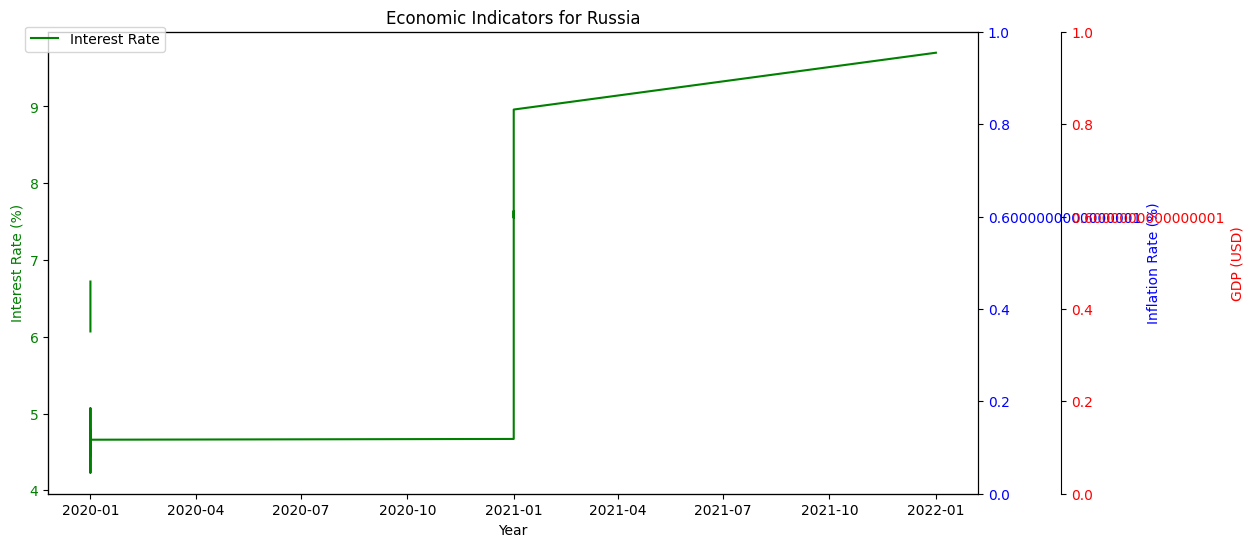

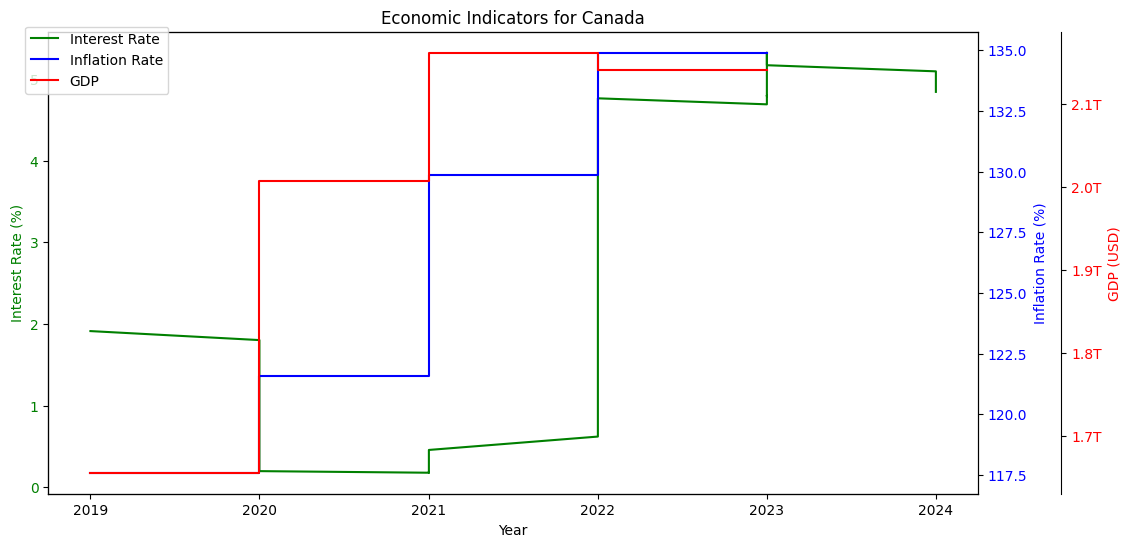

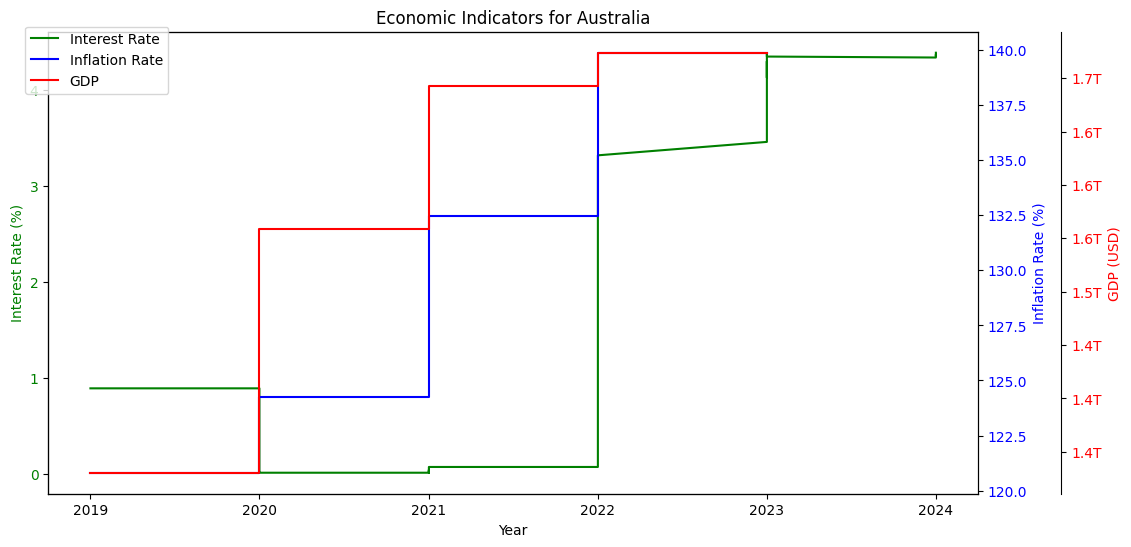

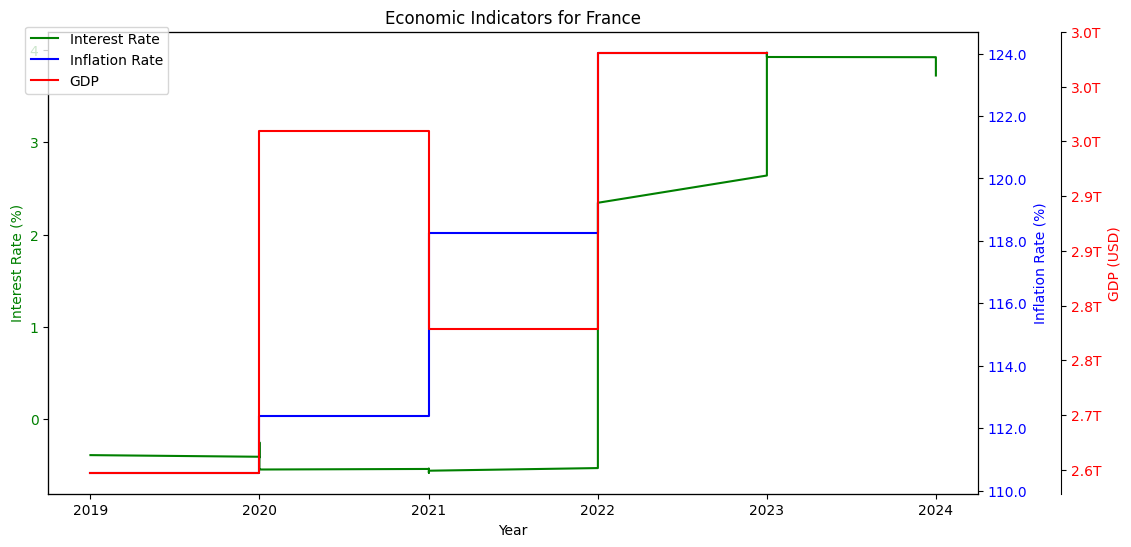

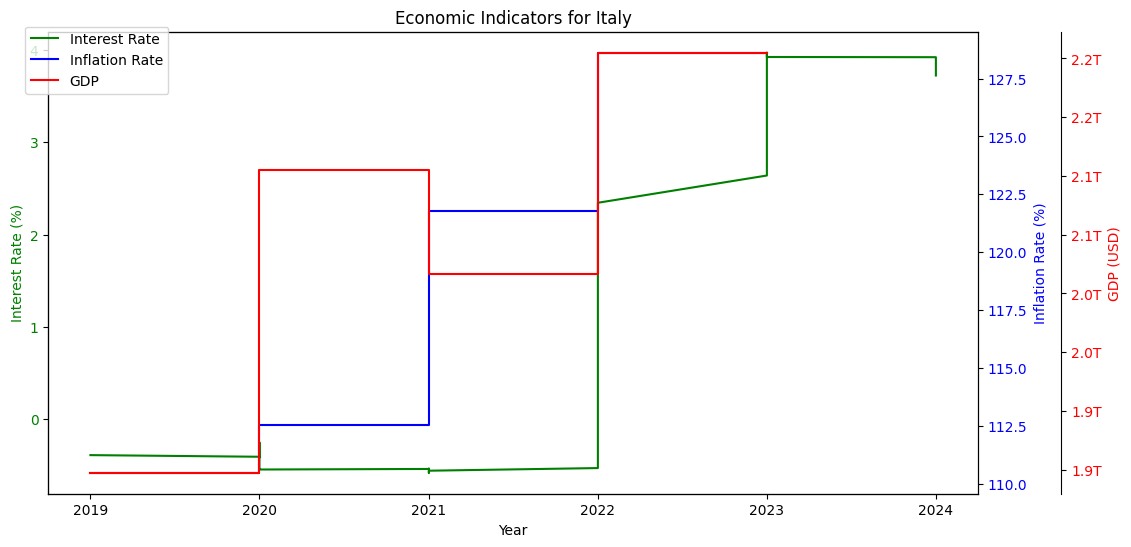

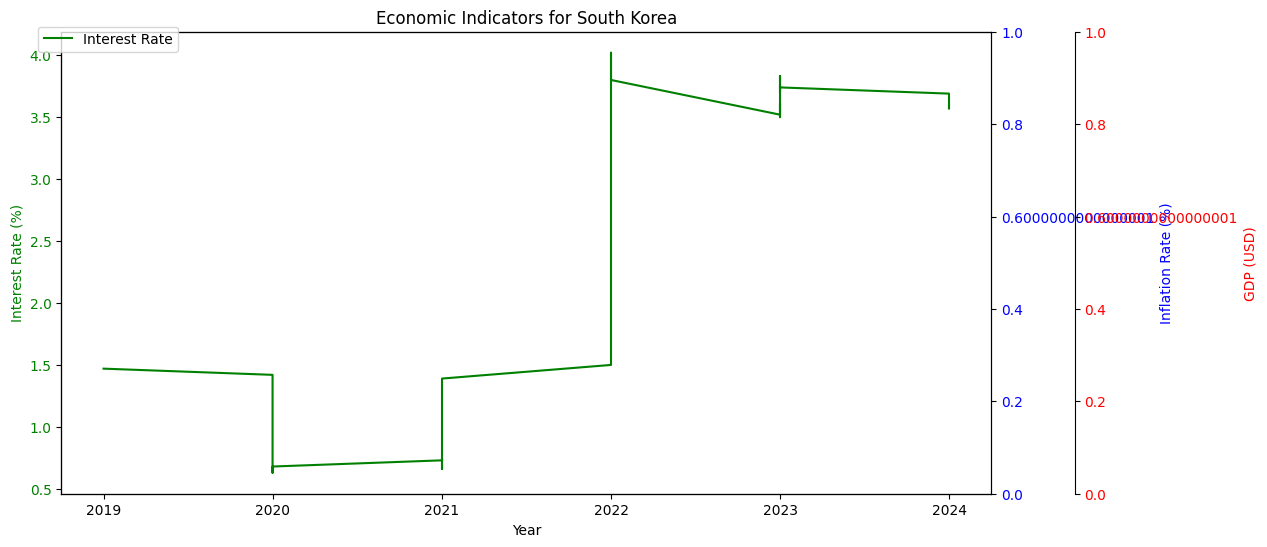

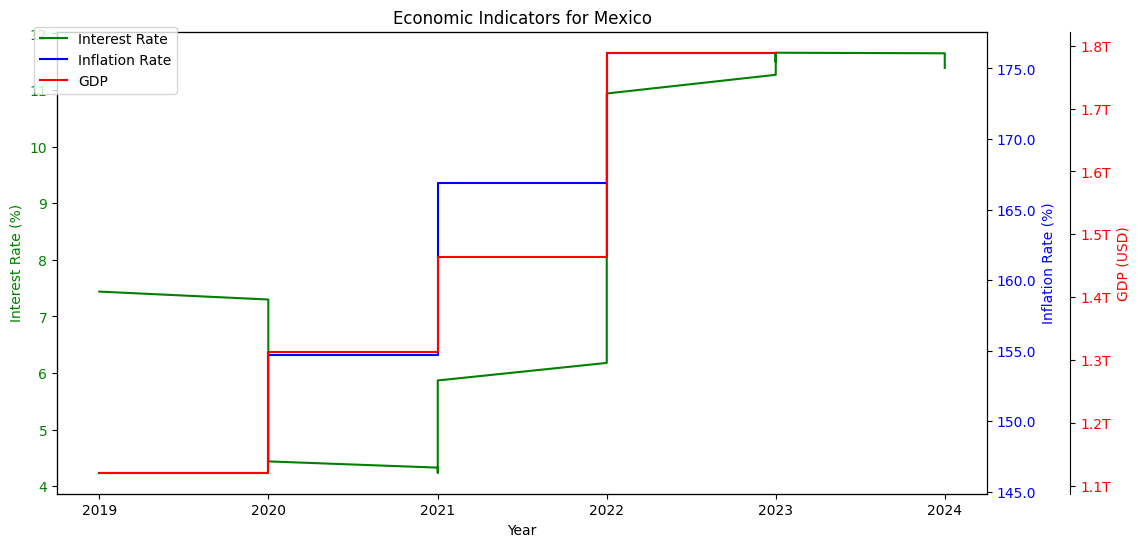

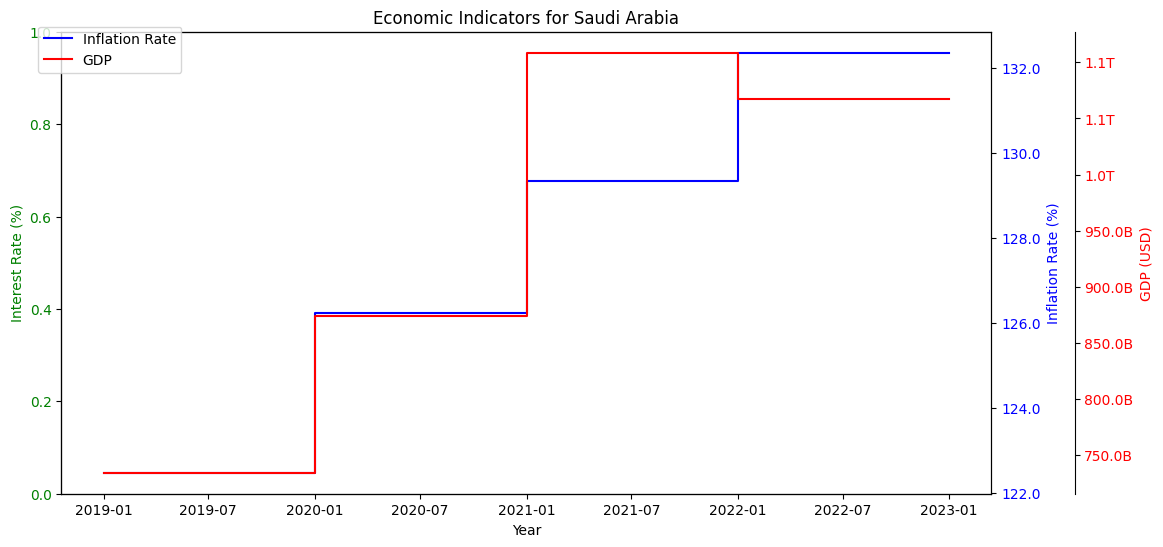

In [7]:
macro_economic_factors = pd.read_csv(MACRO_ECO_FACTORS_DATA_FILE_PATH)
macro_economic_factors['year'] = pd.to_datetime(macro_economic_factors['year'], format='%Y')

# Function to plot interest rate, inflation rate, and GDP for a country
def plot_country_economic_data(country_name):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    # Offset the third axis to the right
    ax3.spines['right'].set_position(('outward', 60))

    # Plotting interest rate
    if f'interest_rate_{country_name}' in macro_economic_factors.columns:
        ax1.plot(macro_economic_factors['year'], macro_economic_factors[f'interest_rate_{country_name}'], 'g-', label='Interest Rate')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Interest Rate (%)', color='g')
    ax1.tick_params(axis='y', labelcolor='g')

    # Plotting inflation rate
    if f'inflation_rate_{country_name}' in macro_economic_factors.columns:
        ax2.plot(macro_economic_factors['year'], macro_economic_factors[f'inflation_rate_{country_name}'], 'b-', label='Inflation Rate')
    ax2.set_ylabel('Inflation Rate (%)', color='b')
    ax2.yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter
    ax2.tick_params(axis='y', labelcolor='b')

    # Plotting GDP
    if f'gdp_{country_name}' in macro_economic_factors.columns:
        ax3.plot(macro_economic_factors['year'], macro_economic_factors[f'gdp_{country_name}'], 'r-', label='GDP')
    ax3.set_ylabel('GDP (USD)', color='r')
    ax3.yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter
    ax3.tick_params(axis='y', labelcolor='r')

    # Setting the title
    plt.title(f'Economic Indicators for {country_name}')

    # Adding legends
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

# Loop through each country and plot the data
for country in list(COUNTRIES.values()):
    plot_country_economic_data(country)